<a href="https://colab.research.google.com/github/pI88Id/MLProject-Incremental.Learning/blob/master/NoStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import copy
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.backends import cudnn
import os
import logging
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import resnet18

#if not os.path.isdir('a'):
  #!git clone https://github.com/pI88Id/MLProject-Incremental.Learning.git
  #os.rename("MLProject-Incremental.Learning","a")

#from a.Cifar100  import Cifar100
#from a.Cifar100 import utils
from Cifar100 import Cifar100
from Cifar100 import utils

**Set Arguments**

In [10]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 100
CLASSES_EACH_TRAIN = 10

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                    # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 5  #30    # Total number of training epochs (iterations over dataset)
STEP_SIZE = 2  #30    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [11]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
                                    ])

# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

**Prepare Network**

In [12]:
net = resnet18()
best_net = resnet18()

net.fc = nn.Linear(net.fc.in_features, NUM_CLASSES)

**Prepare Training**

In [13]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

parameters_to_optimize = net.parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# optimizer = optim.Adam(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

# Define scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train and Test**

In [14]:
net = net.to(DEVICE)
cudnn.benchmark = True # Calling this optimizes runtime

current_step = 0
best_accuracy = 0
loss = 0
index = 0
accuracy_train = []
accuracy_test = []
loss_train = []
loss_test = []

In [15]:
#New variable from our class Cifar100
cifar100 = Cifar100.Cifar100(BATCH_SIZE, NUM_EPOCHS, DEVICE, LR, STEP_SIZE, GAMMA)

tot_step = NUM_CLASSES//CLASSES_EACH_TRAIN

for index in range(0, NUM_CLASSES//CLASSES_EACH_TRAIN):
  start = index*CLASSES_EACH_TRAIN
  stop = (index+1)*CLASSES_EACH_TRAIN

  #Load data from Cifar100
  train_dataset = utils.Cifar100(classes=range(start, stop), train=True, transform=train_transform)
  test_dataset = utils.Cifar100(classes=range(start, stop), train=False, transform=train_transform)
  test_dataset_all= utils.Cifar100(classes=range(stop), train=False, transform=train_transform)
  train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)
  test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8) #Batch_size decrease for GPU ram problems

  # train_dataloader = cifar100.load('train', index=index)
  # test_dataloader = cifar100.load('test', index=index)


  # Start iterating over the epochs
  for epoch in range(NUM_EPOCHS):

    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
    running_correct=0

    # Iterate over the dataset
    for _, images, labels in train_dataloader:

      # Bring data over the device of choice
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train().to(DEVICE)
      optimizer.zero_grad()
      outputs = net(images)

      #Calc the correct for the graph
      _, preds = torch.max(outputs.data, 1)
      running_correct += torch.sum(preds == labels.data).data.item()

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

      current_step += 1

    loss_train.append(loss.item())
    
    accuracy_train.append(running_correct / float(len(train_dataloader)))

    # Step the scheduler
    scheduler.step()

  accuracy, loss = cifar100.test(net, test_dataloader, criterion)

  loss_test.append(loss.item())
  accuracy_test.append(accuracy)
  print('Test Accuracy: {}'.format(accuracy))


  if accuracy > best_accuracy:
    best_net = copy.deepcopy(net)
    best_accuracy = accuracy


Files already downloaded and verified
Files already downloaded and verified
Cifar100 - DATASET CREATED
Train Dataset: 50000
Test Dataset: 10000
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/5, LR = [0.001]
Step 0, Loss 5.114832878112793
Step 10, Loss 3.7776618003845215
Starting epoch 2/5, LR = [0.001]
Step 20, Loss 2.3600919246673584
Step 30, Loss 2.0106046199798584
Starting epoch 3/5, LR = [1e-05]
Step 40, Loss 1.7578074932098389
Step 50, Loss 1.7493127584457397
Starting epoch 4/5, LR = [0.0001]
Step 60, Loss 1.8127235174179077
Step 70, Loss 1.695968747138977
Starting epoch 5/5, LR = [1.0000000000000002e-06]
Step 80, Loss 1.6017626523971558
Step 90, Loss 1.7916892766952515
Test Accuracy: 106.5
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Starting epoch 1/5, LR = [1e-05]
Step 100, Loss 8.059751510620117
Step 110, Loss 8.08112049102783

C:\Users\PiC\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


**Plot**

ValueError: x and y must have same first dimension, but have shapes (5,) and (50,)

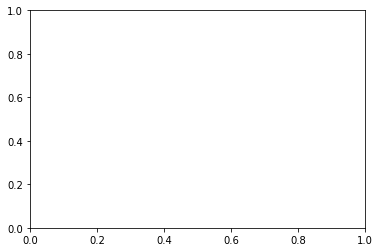

In [19]:
cifar100.plot(accuracy_train, accuracy_test, loss_train, loss_test)
print('Best accuracy', best_accuracy)

